In [248]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn import set_config
from copy import deepcopy
from google.colab import files

uploaded = files.upload()

In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d devarajv88/walmart-sales-dataset

In [ ]:
!unzip walmart-sales-dataset.zip

In [203]:
df = pd.read_csv('Walmart Sales.csv')
df_ml = df

In [204]:
df

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,7969
...,...,...,...,...,...,...,...,...,...,...
550063,1006033,P00372445,M,51-55,13,B,1,1,20,368
550064,1006035,P00375436,F,26-35,1,C,3,0,20,371
550065,1006036,P00375436,F,26-35,15,B,4+,1,20,137
550066,1006038,P00375436,F,55+,1,C,2,0,20,365


In [205]:
df.dtypes

User_ID                        int64
Product_ID                    object
Gender                        object
Age                           object
Occupation                     int64
City_Category                 object
Stay_In_Current_City_Years    object
Marital_Status                 int64
Product_Category               int64
Purchase                       int64
dtype: object

In [206]:
df.isnull().sum()


User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category              0
Purchase                      0
dtype: int64

* Não foi necessário tratar os dados para a Análise Exploratória pois o mesmo não possui dados nulos ou faltantes.

Percentuais e Cálculos

In [253]:
qtd_usuarios_unicos = df['User_ID'].nunique()
qtd_produtos = df['Product_ID'].nunique()
qtd_ocupacoes = df['Occupation'].nunique()
qtd_cidades = df['City_Category'].nunique()
qtd_usuarios_unicos_por_faixa_etaria = df.groupby('Age')['User_ID'].nunique()

qtd_usuarios_feminino =  df[df['Gender'] == 'F']['User_ID'].nunique()
qtd_usuarios_masculino =  df[df['Gender'] == 'M']['User_ID'].nunique()

qtd_total_compras = df['Purchase'].count()

qtd_compras_por_categoria = df.groupby('Product_Category')['Purchase'].count()
qtd_compras_por_product_id = df.groupby('Product_ID')['Purchase'].count()

qtd_compras_por_categoria_genero = df.groupby(['Product_Category', 'Gender'])['Purchase'].count().unstack()

qtd_usuarios_por_cidade = df.groupby('City_Category')['User_ID'].nunique().reset_index()
qtd_usuarios_por_cidade = df.groupby('Product_ID')['User_ID'].nunique().reset_index()

qtd_total_usuarios_por_estado_civil = df['Marital_Status'].value_counts()
qtd_usuarios_estado_civil_0 = df.query('Marital_Status == 0')['User_ID'].nunique()
qtd_usuarios_estado_civil_1 = df.query('Marital_Status == 1')['User_ID'].nunique()

soma_total_compras = df['Purchase'].sum()
soma_compras_por_estado_civil = df.groupby('Marital_Status')['Purchase'].sum()
soma_compras_por_cidade = df.groupby('City_Category')['Purchase'].sum()
soma_compras_por_ocupacao = df_ml.groupby('Occupation')['Purchase'].sum()




In [252]:
qtd_usuarios_unicos, qtd_produtos, qtd_ocupacoes, qtd_cidades

(5891, 3631, 21, 3)

In [263]:
media_compras = soma_total_compras / qtd_total_compras
mediana_compras = df['Purchase'].median()
mediana_compras_por_faixa_etaria = df.groupby('Age')['Purchase'].median()

In [254]:
percentual_compras = ( soma_compras_por_ocupacao / soma_total_compras) * 100
percentual_compras

Occupation
0     12.319443
1      8.217295
10     2.254190
11     2.055536
12     5.910429
13     1.383315
14     5.029421
15     2.298569
16     4.622738
17     7.632387
18     1.179497
19     1.424242
2      4.601182
20     5.725389
3      3.141715
4     12.952068
5      2.210323
6      3.654403
7     10.820167
8      0.286479
9      1.060420
Name: Purchase, dtype: float64

In [210]:
percentual_compras_por_estado_civil = (soma_compras_por_estado_civil / soma_total_compras) * 100
percentual_compras_por_estado_civil

Marital_Status
0    59.047057
1    40.952943
Name: Purchase, dtype: float64

In [211]:
percentual_usuarios_por_faixa_etaria = (qtd_usuarios_unicos_por_faixa_etaria / qtd_usuarios_unicos) * 100
percentual_usuarios_por_faixa_etaria

Age
0-17      3.700560
18-25    18.146325
26-35    34.849771
36-45    19.809879
46-50     9.013750
51-55     8.164997
55+       6.314717
Name: User_ID, dtype: float64

In [212]:
percentual_publico_feminino = (qtd_usuarios_feminino / qtd_usuarios_unicos) * 100
percentual_publico_masculino = (qtd_usuarios_masculino / qtd_usuarios_unicos) * 100
percentual_publico_feminino, percentual_publico_masculino

(28.28042777117637, 71.71957222882362)

In [213]:
percentual_compras_por_cidade = (soma_compras_por_cidade / soma_compras_por_cidade.sum()) * 100
percentual_compras_por_cidade

City_Category
A    25.834381
B    41.515136
C    32.650483
Name: Purchase, dtype: float64

In [214]:
percentual_publico_por_estado_civil_0 = ( qtd_usuarios_estado_civil_0 / qtd_usuarios_unicos ) * 100
percentual_publico_por_estado_civil_1 = ( qtd_usuarios_estado_civil_1 / qtd_usuarios_unicos ) * 100
percentual_publico_por_estado_civil_0, percentual_publico_por_estado_civil_1

(58.0037345102699, 41.99626548973009)

In [215]:
percentual_compras_categoria_produto = (qtd_compras_por_categoria / qtd_compras_por_categoria.sum()) * 100
percentual_compras_categoria_produto

Product_Category
1     25.520118
2      4.338373
3      3.674637
4      2.136645
5     27.438971
6      3.720631
7      0.676462
8     20.711076
9      0.074536
10     0.931703
11     4.415272
12     0.717548
13     1.008784
14     0.276875
15     1.143495
16     1.786688
17     0.105078
18     0.568112
19     0.291419
20     0.463579
Name: Purchase, dtype: float64

In [216]:
percentual_compras_por_product_id = (qtd_compras_por_product_id / qtd_compras_por_product_id.sum()) * 100
percentual_compras_por_product_id_top_10 = percentual_compras_por_product_id.nlargest(10)
percentual_compras_por_product_id_top_10

Product_ID
P00265242    0.341776
P00025442    0.293600
P00110742    0.293055
P00112142    0.283965
P00057642    0.267240
P00184942    0.261786
P00046742    0.261422
P00058042    0.258513
P00059442    0.255605
P00145042    0.255605
Name: Purchase, dtype: float64

In [217]:
media_compras_por_genero = df.groupby('Gender')['Purchase'].mean()
percentual_compras_genero = (df.groupby('Gender')['Purchase'].count() / qtd_total_compras) * 100
percentual_compras_categoria_genero = qtd_compras_por_categoria_genero.div(qtd_compras_por_categoria_genero.sum(axis=1), axis=0) * 100


In [218]:
Q1 = df['Purchase'].quantile(0.25)
Q3 = df['Purchase'].quantile(0.75)
IQR = Q3 - Q1

limite_superior = Q3 + 1.5 * IQR
limite_inferior = Q1 - 1.5 * IQR

outliers = df[(df['Purchase'] > limite_superior) | (df['Purchase'] < limite_inferior)]

Aplicando Machine Learning - Pipeline e Encoding

In [219]:
ordinal_encoder = OrdinalEncoder()
onehot_encoder = OneHotEncoder(sparse_output=False)  ## não se deu bem para usar no dataset
label_encoder = LabelEncoder()

In [220]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   User_ID                     550068 non-null  int64 
 1   Product_ID                  550068 non-null  object
 2   Gender                      550068 non-null  object
 3   Age                         550068 non-null  object
 4   Occupation                  550068 non-null  int64 
 5   City_Category               550068 non-null  object
 6   Stay_In_Current_City_Years  550068 non-null  object
 7   Marital_Status              550068 non-null  int64 
 8   Product_Category            550068 non-null  int64 
 9   Purchase                    550068 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 42.0+ MB


Tratamento dos Dados para os Modelos de Machine Learning

In [221]:
df_ml = df_ml.drop(columns=['User_ID', 'Product_ID'], axis=1)

In [222]:
df_ml['Stay_In_Current_City_Years'] = df_ml['Stay_In_Current_City_Years'].str.replace('+', '').astype(int)

In [223]:
df['Marital_Status'] = df['Marital_Status'].astype(str)
df_ml['Gender'] = df_ml['Gender'].astype(str)
df_ml['City_Category'] = df_ml['City_Category'].astype(str)
df_ml['Occupation'] = df_ml['Occupation'].astype(str)
df_ml['Product_Category'] = df_ml['Product_Category'].astype(str)

In [224]:
faixa_etaria = {
    '0-17': 0,
    '18-25': 1,
    '26-35': 2,
    '36-45': 3,
    '46-50': 4,
    '51-55': 5,
    '55+': 6
}

df_ml['Age'] = df_ml['Age'].map(faixa_etaria)

In [225]:
#ordinal_columns = ['Age', 'Stay_In_Current_City_Years'] - Já tratado manualmente
categoricos_encoder = ['Gender', 'City_Category', 'Occupation', 'Product_Category']


In [226]:
df_ml['Purchase'].describe()

count    550068.000000
mean       9263.968713
std        5023.065394
min          12.000000
25%        5823.000000
50%        8047.000000
75%       12054.000000
max       23961.000000
Name: Purchase, dtype: float64

In [227]:
Q1 = df_ml['Purchase'].quantile(0.25)
Q3 = df_ml['Purchase'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

df_ml = df_ml[(df_ml['Purchase'] >= limite_inferior) & (df_ml['Purchase'] <= limite_superior)]

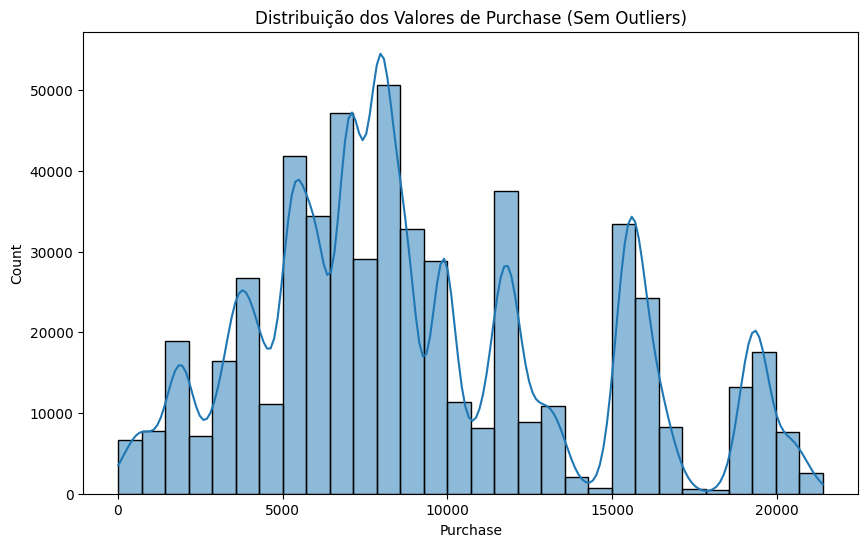

In [228]:
plt.figure(figsize=(10,6))
sns.histplot(df_ml['Purchase'], bins=30, kde=True)
plt.title('Distribuição dos Valores de Purchase (Sem Outliers)')
plt.show()

In [229]:
df_final_ml = df_ml.copy()
for itens in categoricos_encoder:
    df_final_ml[itens] = label_encoder.fit_transform(df_ml[itens])

df_final_ml.head()


,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category,Purchase
0,0,0,2,0,2,0,13,8370
1,0,0,2,0,2,0,0,15200
2,0,0,2,0,2,0,3,1422
3,0,0,2,0,2,0,3,1057
4,1,6,8,2,4,0,18,7969


In [230]:
df_final_ml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 547391 entries, 0 to 550067
Data columns (total 8 columns):
 #   Column                      Non-Null Count   Dtype
---  ------                      --------------   -----
 0   Gender                      547391 non-null  int32
 1   Age                         547391 non-null  int64
 2   Occupation                  547391 non-null  int32
 3   City_Category               547391 non-null  int32
 4   Stay_In_Current_City_Years  547391 non-null  int32
 5   Marital_Status              547391 non-null  int64
 6   Product_Category            547391 non-null  int32
 7   Purchase                    547391 non-null  int64
dtypes: int32(5), int64(3)
memory usage: 27.1 MB


In [231]:
df_final_ml.describe()

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category,Purchase
count,547391.000000,547391.000000,547391.000000,547391.000000,547391.000000,547391.000000,547391.000000,547391.000000
mean,0.752974,2.494630,9.256842,1.042392,1.858476,0.409486,10.373877,9195.627195
std,0.431283,1.352682,6.379338,0.760145,1.289437,0.491739,7.251215,4938.872953
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000
25%,1.000000,2.000000,3.000000,0.000000,1.000000,0.000000,0.000000,5721.000000
50%,1.000000,2.000000,9.000000,1.000000,2.000000,0.000000,15.000000,8038.000000
75%,1.000000,3.000000,15.000000,2.000000,3.000000,1.000000,16.000000,12019.000000
max,1.000000,6.000000,20.000000,2.000000,4.000000,1.000000,19.000000,21399.000000


In [232]:
# Features (X) e alvo para Classificação (y1), Regressão (y2)
X = df_final_ml.drop(['Purchase'], axis=1) # Features
y = df_final_ml['Purchase'] # Labels

Normalização dos Dados (Labels)

In [233]:
y = pd.DataFrame(y)
scaler = RobustScaler().fit(y)
y = scaler.fit_transform(y)
y = pd.DataFrame(y, columns=['Purchase'])
y

,Purchase
0,0.052715
1,1.137186
2,-1.050492
3,-1.108447
4,-0.010956
...,...
547386,-1.217847
547387,-1.217371
547388,-1.254525
547389,-1.218323


Divisão dos dados em treino e teste

X: Dados de treino (75%) com as features para a classificação.
y: Dados de teste (25%) com as features para a classificação.


In [234]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.25, random_state=42)

In [235]:
model_linear_regression = LinearRegression()
model_linear_regression.fit(X_treino, y_treino)
y_pred = model_linear_regression.predict(X_teste)
acuracia = model_linear_regression.score(X_teste, y_teste)
print(f'Acurácia Regressão Linear: {acuracia}') #R2

Acurácia Regressão Linear: 0.18216057398160557


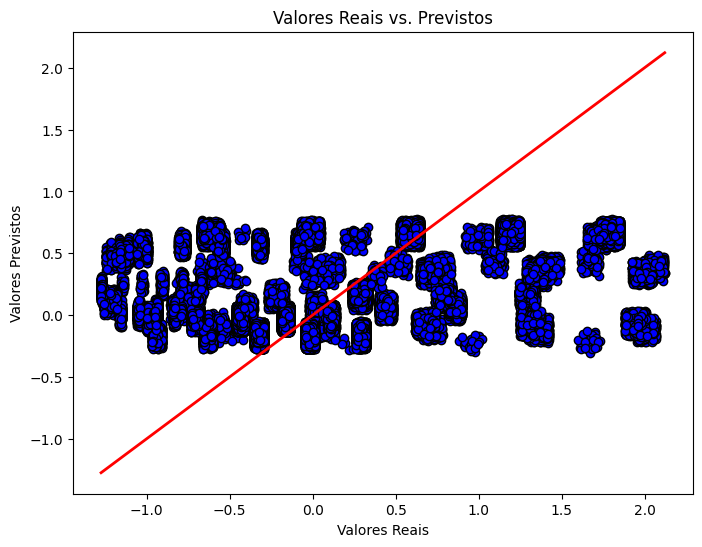

In [236]:
plt.figure(figsize=(8, 6))
plt.scatter(y_teste, y_pred, color='blue', edgecolor='k')
plt.plot([y_teste.min(), y_teste.max()], [y_teste.min(), y_teste.max()], color='red', lw=2)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Previstos')
plt.title('Valores Reais vs. Previstos')
plt.show()

In [237]:
model_decision_tree = DecisionTreeRegressor()
model_decision_tree.fit(X_treino, y_treino)

y_pred_dt = model_decision_tree.predict(X_teste)
acuracia_dt = model_decision_tree.score(X_teste, y_teste)
print(f'Acurácia (Árvore de Decisão): {acuracia_dt}')


Acurácia (Árvore de Decisão): 0.6413364665743978


In [238]:
model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X_treino, y_treino)

y_pred_ridge = model_ridge.predict(X_teste)
acuracia_ridge = model_ridge.score(X_teste, y_teste)
print(f'Acurácia da Regressão Ridge: {acuracia_ridge}')

Acurácia da Regressão Ridge: 0.18216057547126896


In [239]:
model_random_forest = RandomForestRegressor(n_estimators=10)
model_random_forest.fit(X_treino, y_treino)

acuracia = model_random_forest.score(X_teste, y_teste)
print(f'Acurácia Random Forest: {acuracia}')

c:\Users\anne.borges\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Acurácia Random Forest: 0.6458359630692565


In [240]:
model_lasso = Lasso()
model_lasso.fit(X_treino, y_treino)

y_pred_lasso = model_lasso.predict(X_teste)

acuracia_lasso = model_lasso.score(X_teste, y_teste)
print(f'Acurácia Regressão Lasso: {acuracia_lasso}')

Acurácia Regressão Lasso: 0.1489211767119788


In [241]:

model_gradient_boosting_regressor = GradientBoostingRegressor()
model_gradient_boosting_regressor.fit(X_treino, y_treino)

y_pred_gb = model_gradient_boosting_regressor.predict(X_teste)

acuracia_gb = model_gradient_boosting_regressor.score(X_teste, y_teste)
print(f'Acurácia Gradient Boosting: {acuracia_gb}')


c:\Users\anne.borges\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


Acurácia Gradient Boosting: 0.6282319128107754


Análise da Performance dos Modelos no Geral

In [244]:
models = [
    (model_decision_tree, 'Árvore de Decisão'),
    (model_linear_regression, 'Regressão Linear'),
    (model_gradient_boosting_regressor, 'Gradient Boosting'),
    (model_random_forest, 'Random Forest'),
    (model_ridge, 'Regressão Ridge'),
    (model_lasso, 'Regressão Lasso'),
]

In [246]:
def evaluate_regression_model(model, X_teste, y_teste):
    y_pred = model.predict(X_teste)
    mse = mean_squared_error(y_teste, y_pred)
    mae = mean_absolute_error(y_teste, y_pred)
    r2 = r2_score(y_teste, y_pred)

    print(f'Mean Squared Error (MSE): {mse:.4f}')
    print(f'Mean Absolute Error (MAE): {mae:.4f}')
    print(f'R² Score: {r2:.4f}')


In [249]:
for model, name in models:
    print(f'\nMétricas do Modelo {name}:')
    evaluate_regression_model(model, X_teste, y_teste)


Métricas do Modelo Árvore de Decisão:
Mean Squared Error (MSE): 0.2212
Mean Absolute Error (MAE): 0.3445
R² Score: 0.6413

Métricas do Modelo Regressão Linear:
Mean Squared Error (MSE): 0.2212
Mean Absolute Error (MAE): 0.3445
R² Score: 0.6413

Métricas do Modelo Gradient Boosting:
Mean Squared Error (MSE): 0.2293
Mean Absolute Error (MAE): 0.3663
R² Score: 0.6282

Métricas do Modelo Random Forest:
Mean Squared Error (MSE): 0.2184
Mean Absolute Error (MAE): 0.3436
R² Score: 0.6458

Métricas do Modelo Regressão Ridge:
Mean Squared Error (MSE): 0.5043
Mean Absolute Error (MAE): 0.5426
R² Score: 0.1822

Métricas do Modelo Regressão Lasso:
Mean Squared Error (MSE): 0.5248
Mean Absolute Error (MAE): 0.5612
R² Score: 0.1489


Análise Exploratória - Gráficos

Matriz de Correlação

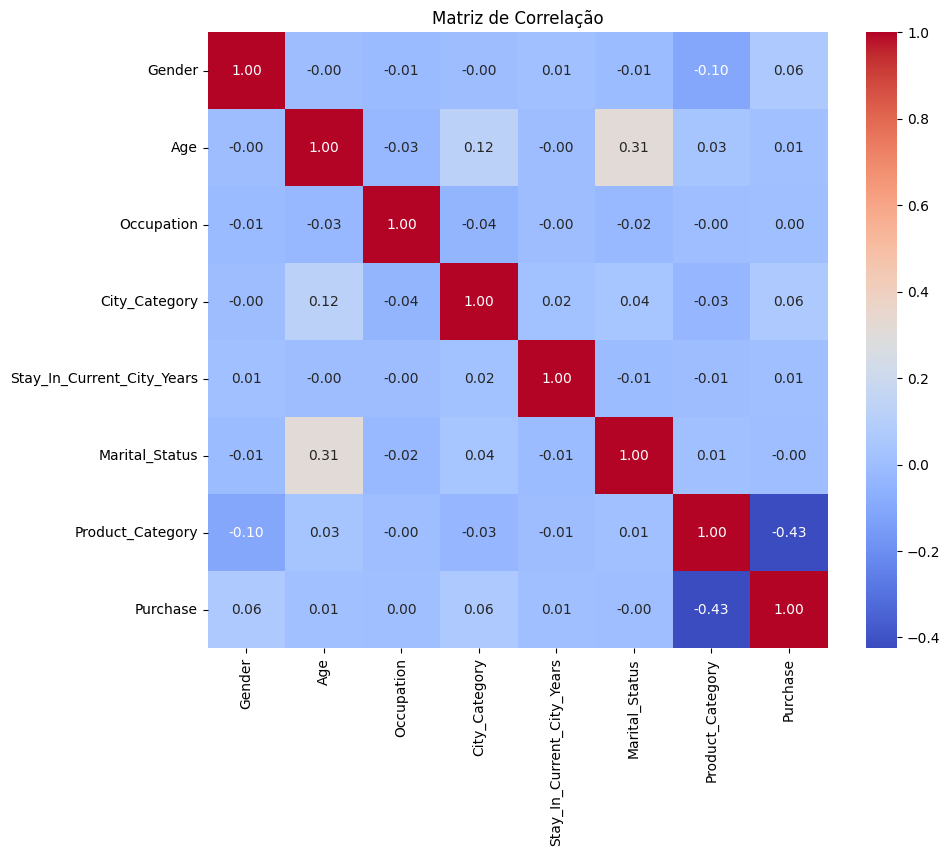

In [259]:
correlacao_matrix = df_final_ml.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlacao_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matriz de Correlação")
plt.show()

Distribuição dos Clientes

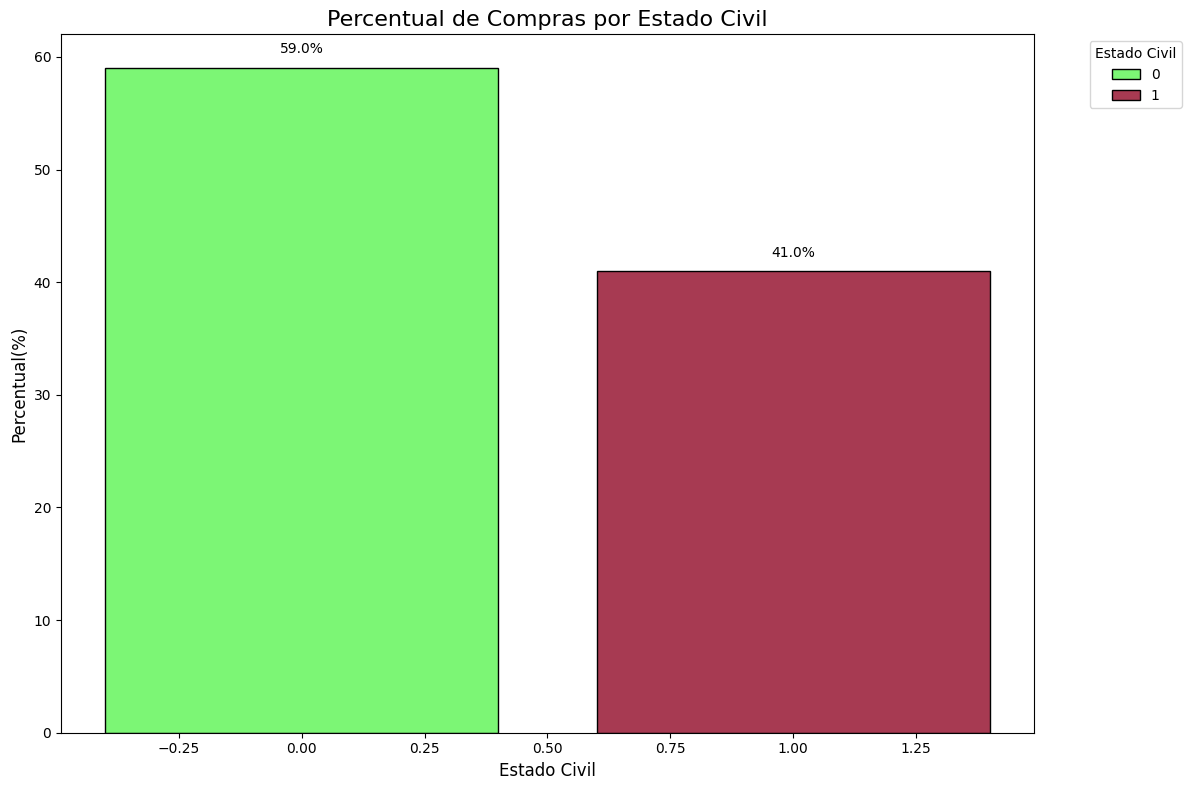

In [126]:
num_categorias = len(df['Marital_Status'])
cores_aleatorias = np.random.rand(num_categorias, 3)

plt.figure(figsize=(12, 8))

barras = plt.bar(percentual_compras_por_estado_civil.index, 
        percentual_compras_por_estado_civil.values, 
        color=cores_aleatorias,
        edgecolor='black')

plt.title('Percentual de Compras por Estado Civil', fontsize=16)
plt.xlabel('Estado Civil', fontsize=12)
plt.ylabel('Percentual(%)', fontsize=12)
plt.legend(barras, percentual_compras_por_estado_civil.index, 
           title='Estado Civil', bbox_to_anchor=(1.05, 1), loc='upper left')

for i in range(len(percentual_compras_por_estado_civil)):
    plt.text(i, percentual_compras_por_estado_civil.values[i] + 1,
             f'{percentual_compras_por_estado_civil.values[i]:.1f}%',
             ha='center', va='bottom')
    

plt.tight_layout()
plt.show()


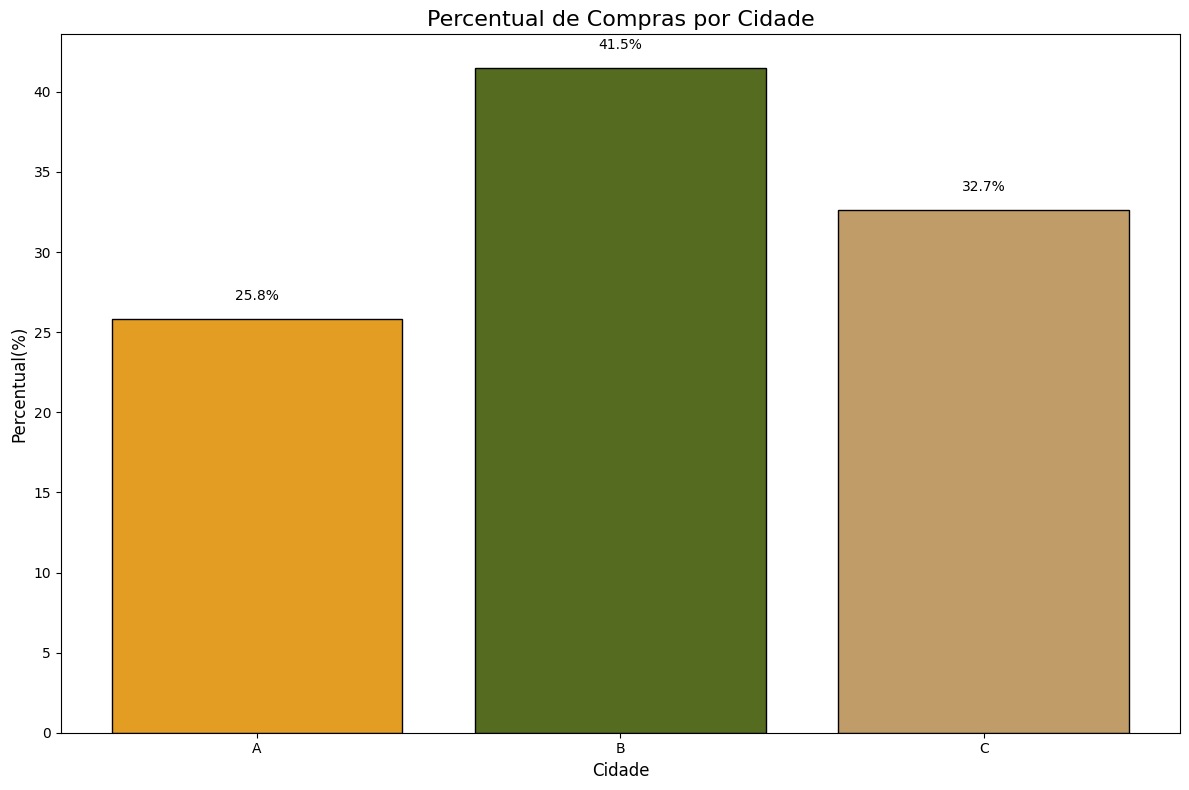

In [261]:
num_categorias = len(df['City_Category'])
cores_aleatorias = np.random.rand(num_categorias, 3)

plt.figure(figsize=(12, 8))

plt.bar(percentual_compras_por_cidade.index, 
        percentual_compras_por_cidade.values, 
        color=cores_aleatorias, 
        edgecolor='black')

plt.title('Percentual de Compras por Cidade', fontsize=16)
plt.xlabel('Cidade', fontsize=12)
plt.ylabel('Percentual(%)', fontsize=12)

for i in range(len(percentual_compras_por_cidade)):
    plt.text(i, percentual_compras_por_cidade.values[i] + 1,
             f'{percentual_compras_por_cidade.values[i]:.1f}%',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()


Análise Exploratória - Gráficos

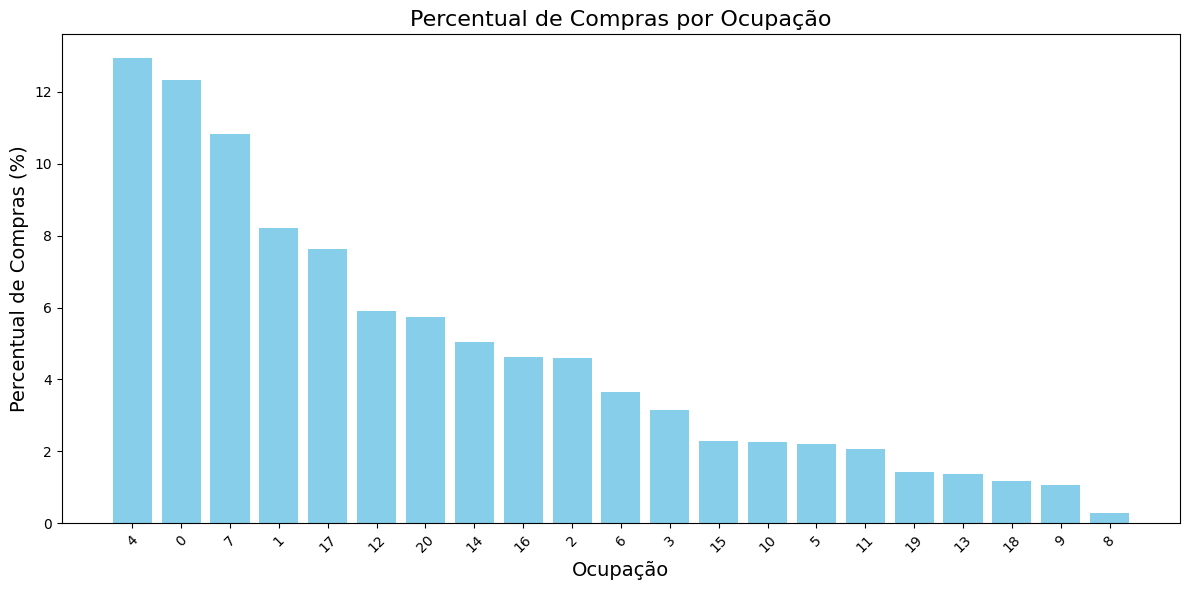

In [256]:
percentual_compras = percentual_compras.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(percentual_compras.index, percentual_compras, color='skyblue')
plt.title('Percentual de Compras por Ocupação', fontsize=16)
plt.xlabel('Ocupação', fontsize=14)
plt.ylabel('Percentual de Compras (%)', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

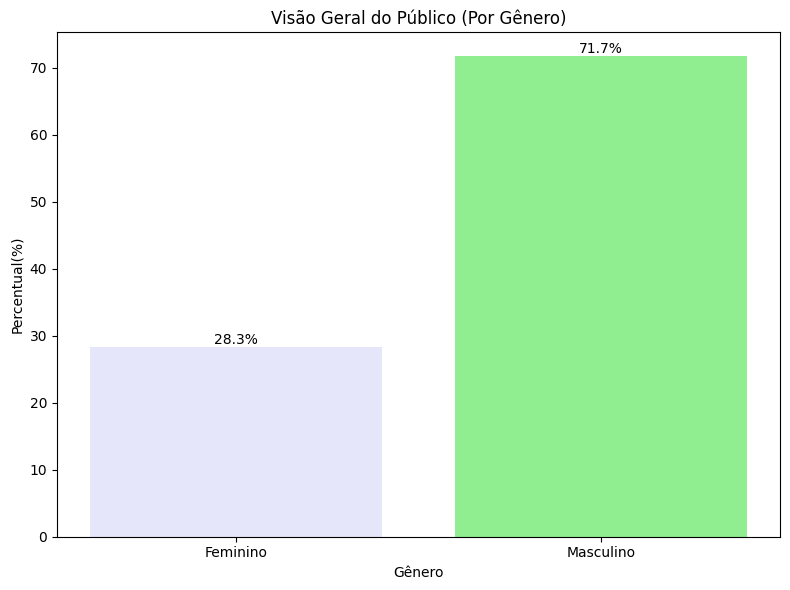

In [262]:
categorias = ['Feminino', 'Masculino']
percentuais = [percentual_publico_feminino, percentual_publico_masculino]

fig, ax = plt.subplots(figsize=(8, 6))

bars = ax.bar(categorias, percentuais, color=['lavender', 'lightgreen'])

plt.xlabel('Gênero')
plt.ylabel('Percentual(%)')
plt.title('Visão Geral do Público (Por Gênero)')

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(percentual_usuarios_por_faixa_etaria.index, 
        percentual_usuarios_por_faixa_etaria.values, 
        color='skyblue', 
        edgecolor='black')

plt.title('Percentual de Usuários por Faixa Etária', fontsize=16)
plt.xlabel('Faixa Etária', fontsize=12)
plt.ylabel('Percentual (%)', fontsize=12)

for i in range(len(percentual_usuarios_por_faixa_etaria)):
    plt.text(i, percentual_usuarios_por_faixa_etaria.values[i] + 1,
             f'{percentual_usuarios_por_faixa_etaria.values[i]:.1f}%',
             ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(mediana_compras_por_faixa_etaria.index, mediana_compras_por_faixa_etaria.values, marker='o', linestyle='-', color='b')

for i, value in enumerate(mediana_compras_por_faixa_etaria):
    plt.text(i, value + 1, str(value), ha='center', va='bottom')

plt.xlabel('Faixa Etária')
plt.ylabel('Mediana de Compras')
plt.title('Mediana de Compras por Faixa Etária')

plt.show()


Visão Geral das Compras

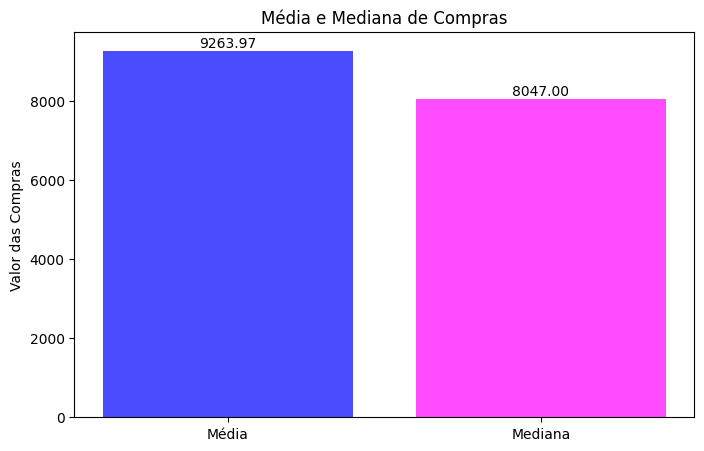

In [268]:
labels = ['Média', 'Mediana']
valores = [media_compras, mediana_compras]

x = np.arange(len(labels))

plt.figure(figsize=(8, 5))
bars = plt.bar(x, valores, color=['blue', 'magenta'], alpha=0.7)

plt.title('Média e Mediana de Compras')
plt.ylabel('Valor das Compras')
plt.xticks(x, labels)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

plt.show()

In [ ]:

fig, ax = plt.subplots(figsize=(8, 6))

percentual_compras_genero.plot(kind='bar', color=['lavender', 'lightgreen'], ax=ax)

plt.xlabel('Faixa Etária')
plt.ylabel('Percentual(%)')
plt.title('Percentual de Compras por Gênero')
ax.legend(title='Gênero', bbox_to_anchor=(1.05, 1), loc='upper left')

for i, value in enumerate(percentual_compras_genero):
    perc = percentual_compras_genero.iloc[i]
    ax.text(i, value + 1, f'{perc:.2f}%', ha='center', va='bottom', color='black')

plt.show()


Distribuição de Vendas por Categoria de Produto

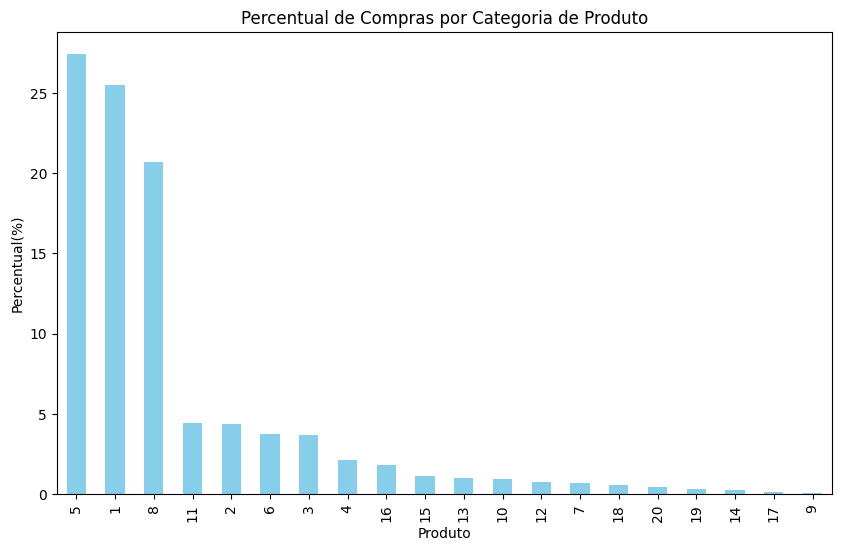

In [257]:
percentual_compras_categoria_produto = percentual_compras_categoria_produto.sort_values(ascending=False)

percentual_compras_categoria_produto.plot(kind='bar', color='skyblue', figsize=(10, 6))
percentual_compras_categoria_produto = percentual_compras_categoria_produto.sort_values(ascending=False)


plt.xlabel('Produto')
plt.ylabel('Percentual(%)')
plt.title('Percentual de Compras por Categoria de Produto')

for i, value in enumerate(percentual_compras_categoria_produto):
    perc = percentual_compras_categoria_produto.iloc[i]
    ax.text(i, value + 1, f'{perc:.2f}%', ha='center', va='bottom', color='black')

plt.show()

In [ ]:

percentual_compras_por_product_id_top_10.plot(kind='bar', color='skyblue', figsize=(10, 6))
percentual_compras_por_product_id_top_10 = percentual_compras_por_product_id_top_10.sort_values(ascending=False)


plt.xlabel('Product Id')
plt.ylabel('Percentual(%)')
plt.title('Percentual Product Id Mais Vendidos (Top 10)')


plt.show()

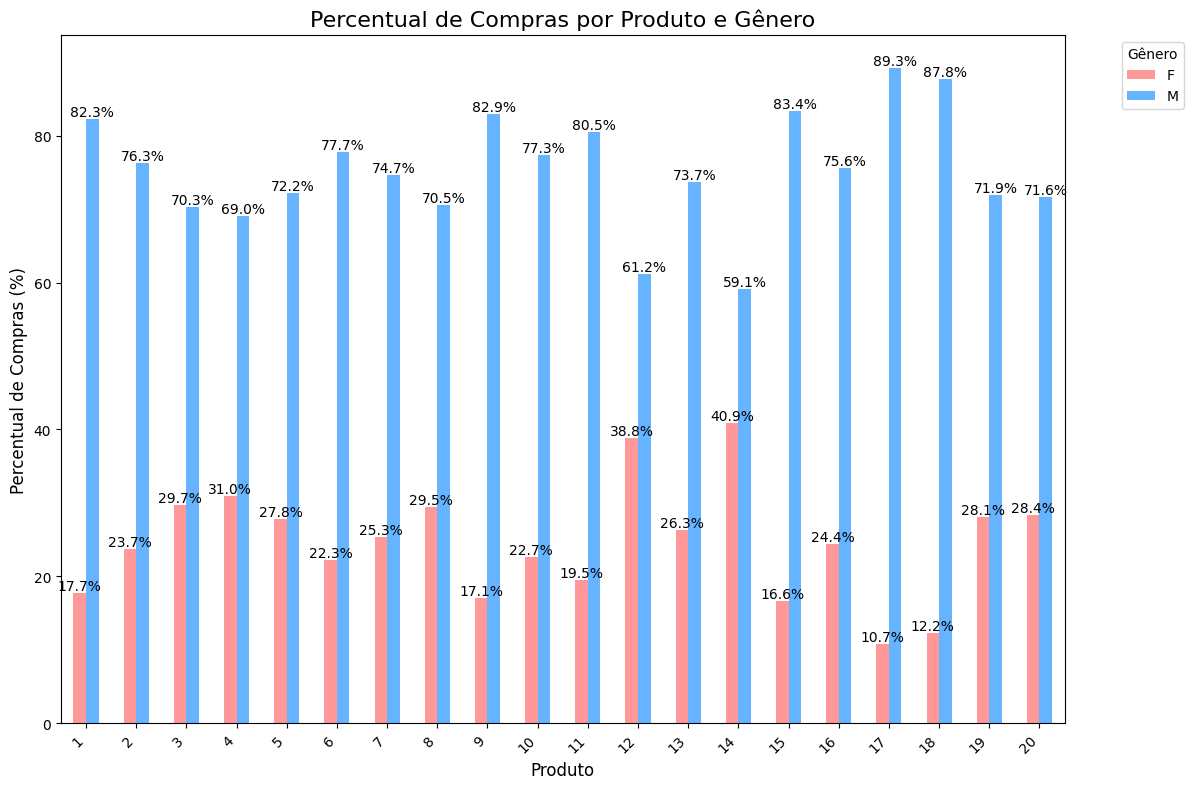

In [258]:
fig, ax = plt.subplots(figsize=(12, 8))

percentual_compras_categoria_genero.plot(kind='bar', ax=ax, color=['#ff9999', '#66b3ff'])

ax.set_title('Percentual de Compras por Produto e Gênero', fontsize=16)
ax.set_xlabel('Produto', fontsize=12)
ax.set_ylabel('Percentual de Compras (%)', fontsize=12)

ax.legend(title='Gênero', bbox_to_anchor=(1.05, 1), loc='upper left')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()


In [ ]:
df.boxplot("Purchase", by = "Gender")
df.boxplot("Purchase", by = "Occupation")
df.boxplot("Purchase", by = "Marital_Status")
df.boxplot("Purchase", by = "Product_Category")
df.boxplot("Purchase", by = "City_Category")
df.boxplot("Purchase", by = "Stay_In_Current_City_Years")
